In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import defaultdict, Counter
import random

C:\Users\guilh\AppData\Local\Temp\ipykernel_23896\1085711447.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ROOT = Path(r"C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes")
CLASSES = ['WBC', 'RBC', 'Platelets']
SPLITS = ['train', 'val', 'test']

In [3]:
def load_labels(split):
    label_dir = ROOT / 'labels' / split
    data = []
    for lbl in label_dir.glob('*.txt'):
        with open(lbl) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    c, x, y, w, h = map(float, parts)
                    data.append({'split': split, 'class': int(c), 'x': x, 'y': y, 'w': w, 'h': h, 'file': lbl.stem})
    return data

In [4]:
all_data = []
for split in SPLITS:
    all_data.extend(load_labels(split))
df = pd.DataFrame(all_data)

In [5]:
df.head()

,split,class,x,y,w,h,file
0,train,0,0.508333,0.545455,0.283333,0.303030,BA_100102
1,train,2,0.230556,0.595041,0.061111,0.055096,BA_100102
2,train,2,0.201389,0.768595,0.052778,0.044077,BA_100102
3,train,1,0.991667,0.067493,0.016667,0.107438,BA_100102
4,train,1,0.923611,0.247934,0.152778,0.225895,BA_100102


In [6]:
df.describe()

,class,x,y,w,h
count,297993.000000,297993.000000,297993.000000,297993.000000,297993.000000
mean,1.004967,0.501654,0.504723,0.187484,0.187486
std,0.305132,0.311295,0.307861,0.073377,0.074357
min,0.000000,0.000000,0.002755,0.000000,0.000000
25%,1.000000,0.206944,0.214876,0.150000,0.148760
50%,1.000000,0.502778,0.504132,0.197222,0.195592
75%,1.000000,0.797222,0.792011,0.222222,0.220386
max,2.000000,1.006944,1.005510,0.775000,0.887052


In [7]:
print(f"Total boxes: {len(df)}")
print(f"Total images: {df['file'].nunique()}")
print(f"Avg boxes per image: {len(df) / df['file'].nunique():.2f}")

Total boxes: 297993
Total images: 16873
Avg boxes per image: 17.66


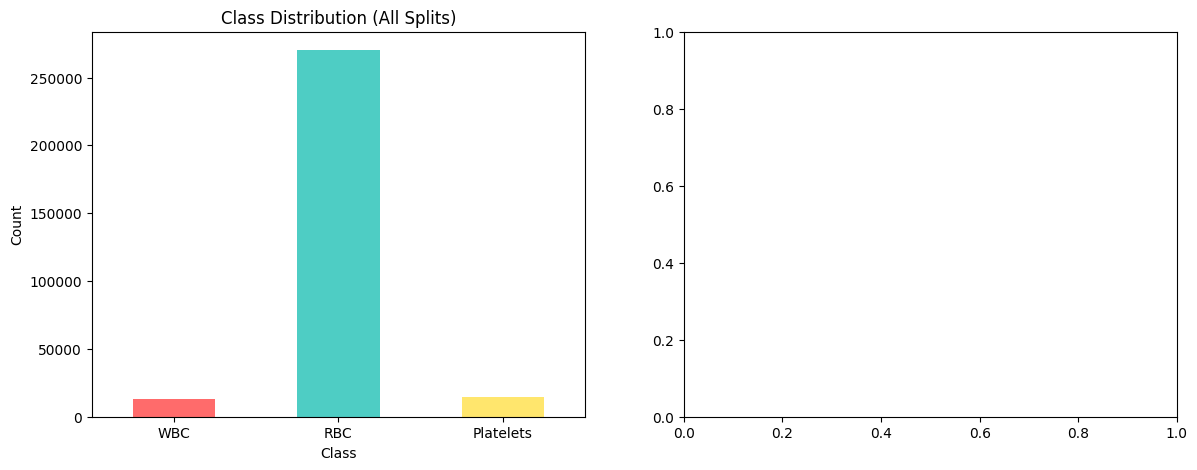

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['class'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#4ecdc4', '#ffe66d'])
axes[0].set_title('Class Distribution (All Splits)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(CLASSES, rotation=0)
plt.show()

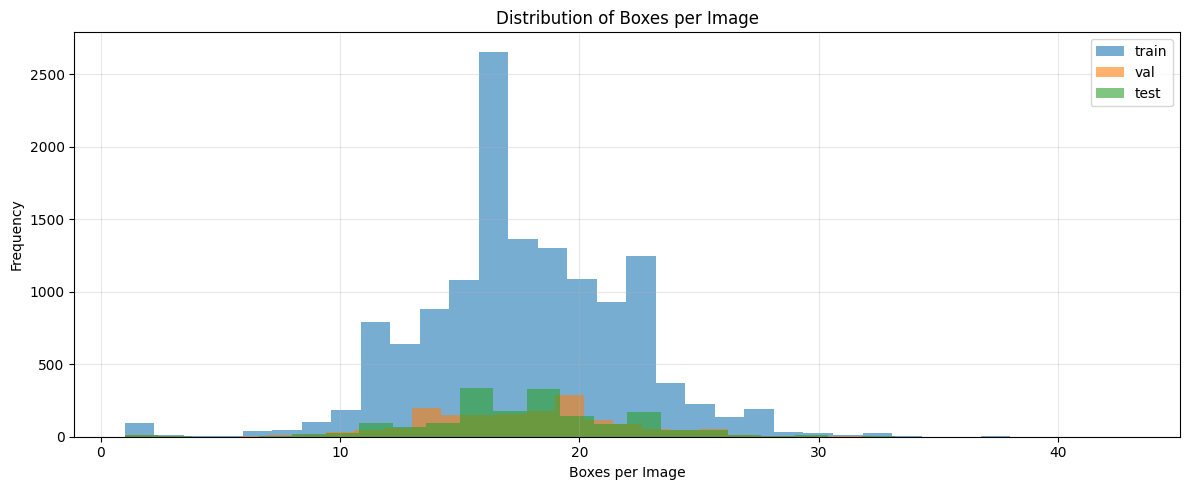

In [9]:
boxes_per_img = df.groupby(['split', 'file']).size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(12, 5))
for split in SPLITS:
    data = boxes_per_img[boxes_per_img['split'] == split]['count']
    ax.hist(data, bins=30, alpha=0.6, label=split)
ax.set_xlabel('Boxes per Image')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Boxes per Image')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

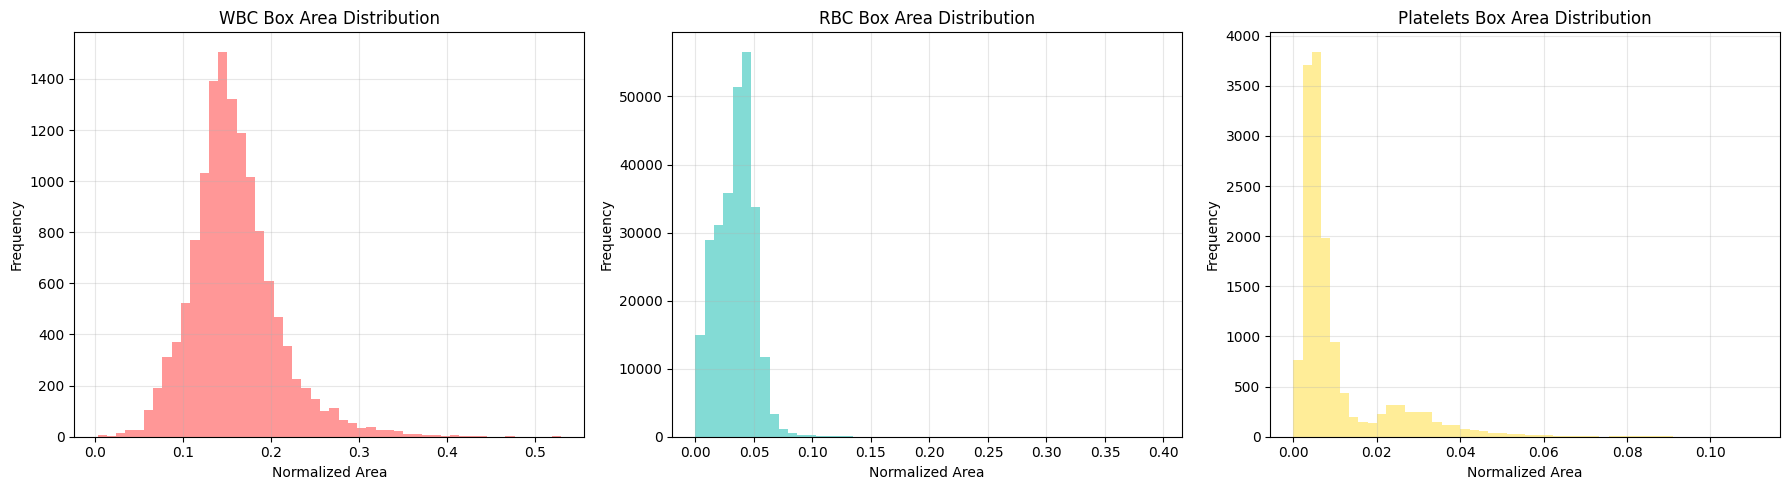

In [10]:
df['area'] = df['w'] * df['h']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, cls in enumerate(CLASSES):
    data = df[df['class'] == i]['area']
    axes[i].hist(data, bins=50, color=['#ff6b6b', '#4ecdc4', '#ffe66d'][i], alpha=0.7)
    axes[i].set_title(f'{cls} Box Area Distribution')
    axes[i].set_xlabel('Normalized Area')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
df['aspect_ratio'] = df['w'] / df['h']

In [12]:
img_sizes = []
for split in SPLITS:
    img_dir = ROOT / 'images' / split
    for img_path in list(img_dir.glob('*'))[:500]:
        img = Image.open(img_path)
        img_sizes.append({'split': split, 'width': img.width, 'height': img.height})
img_df = pd.DataFrame(img_sizes)

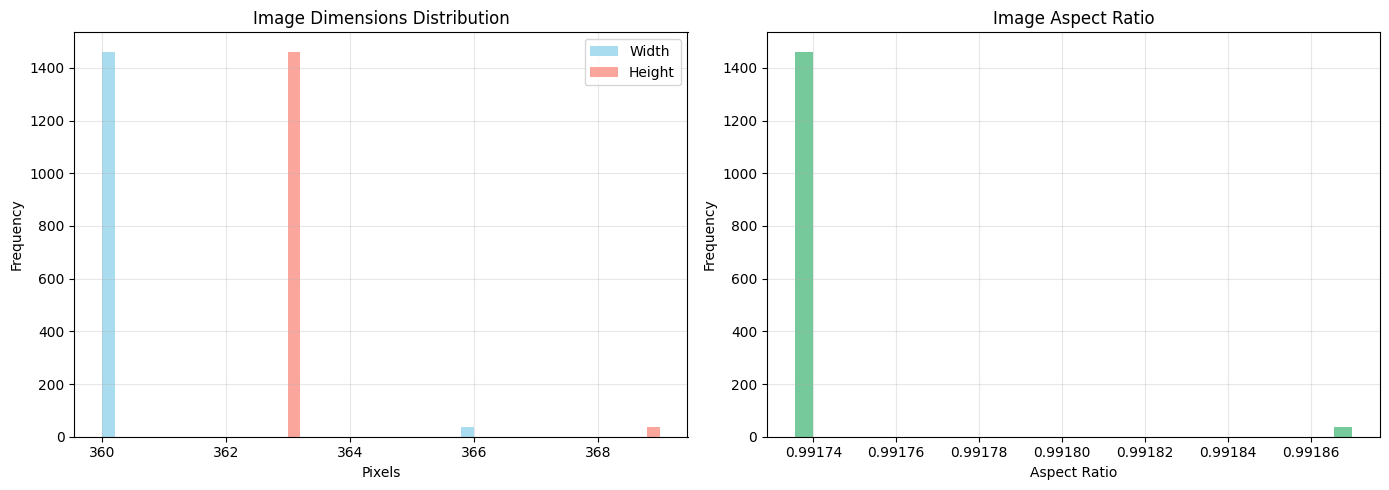

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(img_df['width'], bins=30, alpha=0.7, color='skyblue', label='Width')
axes[0].hist(img_df['height'], bins=30, alpha=0.7, color='salmon', label='Height')
axes[0].set_xlabel('Pixels')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Dimensions Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)
img_df['aspect'] = img_df['width'] / img_df['height']
axes[1].hist(img_df['aspect'], bins=30, color='mediumseagreen', alpha=0.7)
axes[1].set_xlabel('Aspect Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Aspect Ratio')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

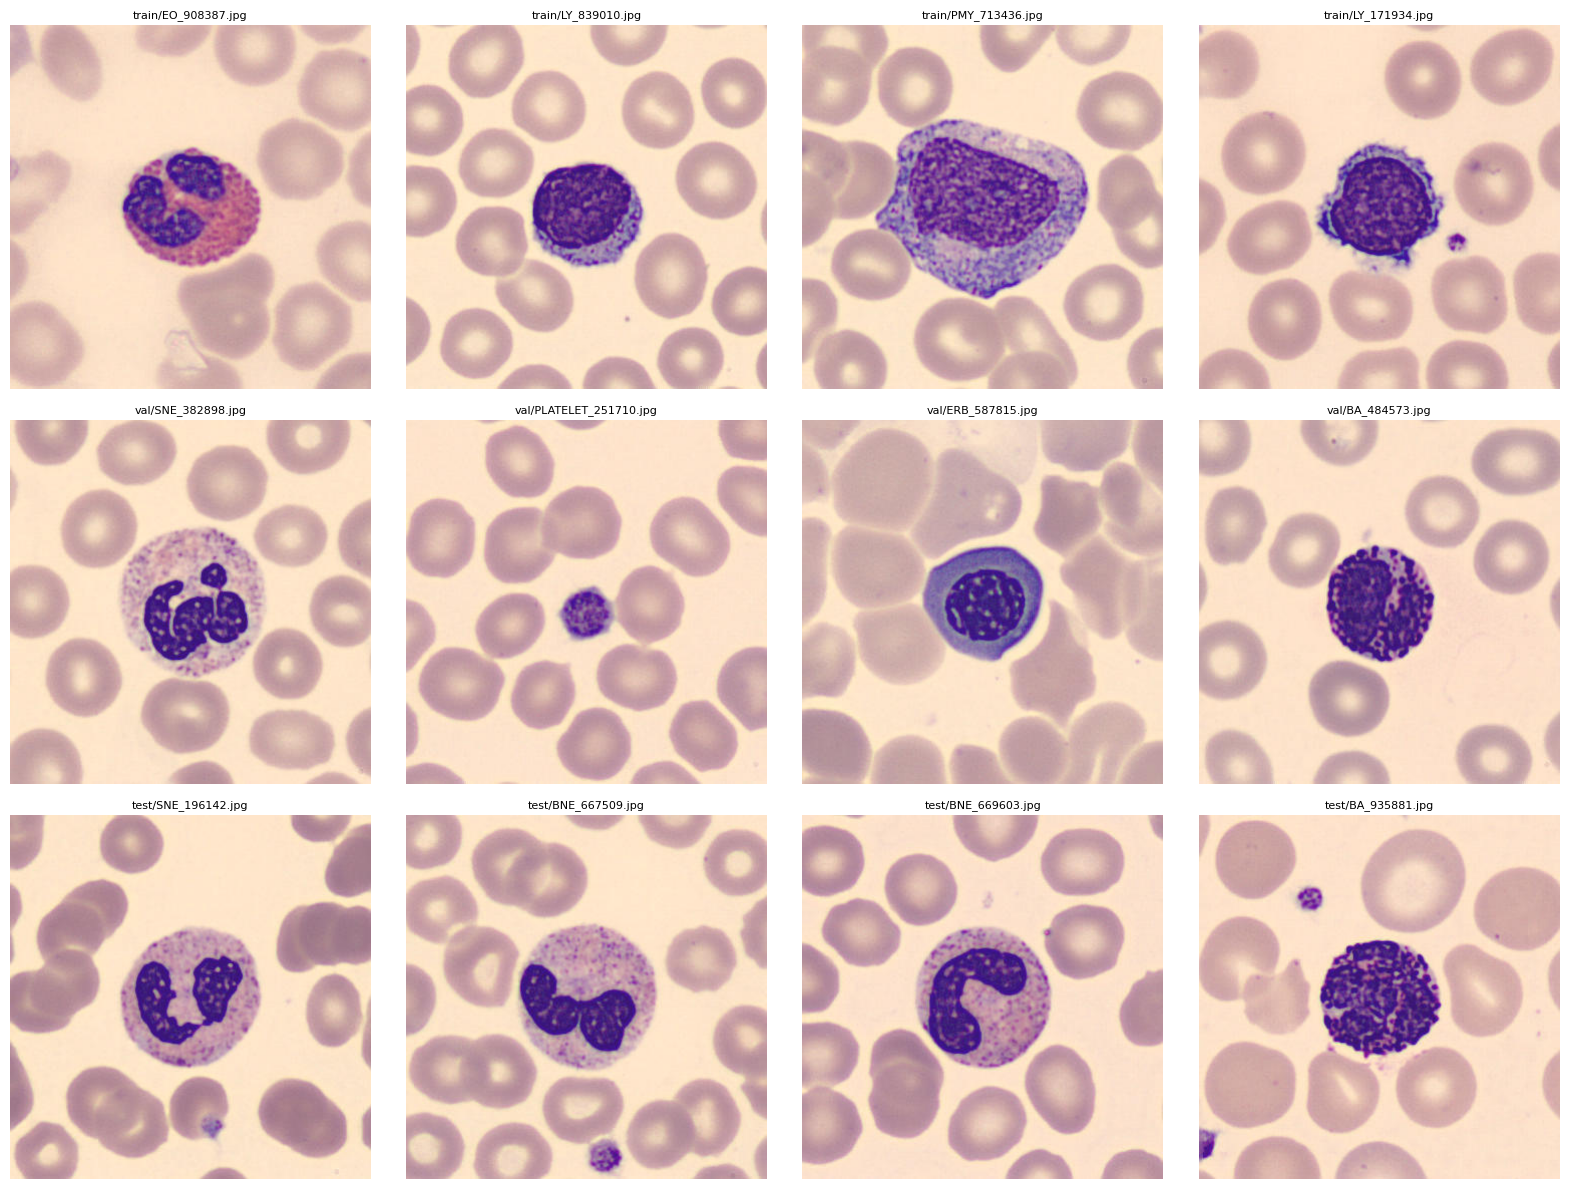

In [14]:
def visualize_samples(n=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    samples = []
    for split in SPLITS:
        img_dir = ROOT / 'images' / split
        samples.extend(random.sample(list(img_dir.glob('*')), k=4))
    for idx, img_path in enumerate(samples[:n]):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"{img_path.parent.name}/{img_path.name}", fontsize=8)
    plt.tight_layout()
    plt.show()
visualize_samples()

In [15]:
summary = []
for split in SPLITS:
    split_df = df[df['split'] == split]
    n_imgs = split_df['file'].nunique()
    n_boxes = len(split_df)
    for cls in range(3):
        cls_count = len(split_df[split_df['class'] == cls])
        summary.append({'Split': split, 'Class': CLASSES[cls], 'Boxes': cls_count, 'Images': n_imgs})
summary_df = pd.DataFrame(summary)
pivot = summary_df.pivot_table(index='Class', columns='Split', values='Boxes', fill_value=0)
print(pivot)
print(f"\nTotal boxes: {len(df)}")
print(f"Total images: {df['file'].nunique()}")

Split         test     train      val
Class                                
Platelets   1517.0   11721.0   1378.0
RBC        26948.0  216469.0  26824.0
WBC         1327.0   10462.0   1347.0

Total boxes: 297993
Total images: 16873
